In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set, explode
from pyspark.ml.fpm import FPGrowth
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 1: Load the dataset
original_file_path = 'purchase_pattern_analysis_table.csv'
data = pd.read_csv(original_file_path)

In [ ]:
data.head()

,BillNo,Itemname,Quantity,Present_Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
data.tail()

,BillNo,Itemname,Quantity,Present_Date,Price,CustomerID,Country
995,536520,SKULLS STORAGE BOX SMALL,2,01-12-2010 12:43,2.10,14729.0,United Kingdom
996,536520,REX CASH+CARRY JUMBO SHOPPER,2,01-12-2010 12:43,0.95,14729.0,United Kingdom
997,536520,JUMBO STORAGE BAG SKULLS,1,01-12-2010 12:43,1.95,14729.0,United Kingdom
998,536520,GARDEN PATH JOURNAL,1,01-12-2010 12:43,2.55,14729.0,United Kingdom
999,536520,HEART OF WICKER SMALL,2,01-12-2010 12:43,1.65,14729.0,United Kingdom


In [ ]:
# Dataset Summary
print("Dataset Info:")
data.info()
print("\nSummary Statistics:")
data.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BillNo        1000 non-null   int64  
 1   Itemname      999 non-null    object 
 2   Quantity      1000 non-null   int64  
 3   Present_Date  1000 non-null   object 
 4   Price         1000 non-null   float64
 5   CustomerID    999 non-null    float64
 6   Country       1000 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB

Summary Statistics:


,BillNo,Quantity,Price,CustomerID
count,1000.000000,1000.000000,1000.000000,999.000000
mean,536421.874000,12.949000,3.005930,15999.825826
std,41.974778,38.334605,5.845525,1863.429271
min,536365.000000,1.000000,0.000000,12431.000000
25%,536394.000000,2.000000,1.250000,14688.000000
50%,536409.000000,4.000000,2.100000,16098.000000
75%,536446.000000,12.000000,3.750000,17908.000000
max,536520.000000,600.000000,165.000000,18085.000000


In [ ]:
data.isnull().sum()

,0
BillNo,0
Itemname,1
Quantity,0
Present_Date,0
Price,0
CustomerID,1
Country,0


In [ ]:
# Step 2: Data Cleaning
# Remove duplicates
data = data.drop_duplicates()

In [ ]:
# Mode imputation for missing values in `Itemname` and `BillNo`
itemname_mode = data['Itemname'].mode()[0]  # Calculate mode for Itemname
custid_mode = data['CustomerID'].mode()[0]  # Calculate mode for Customer ID
data['Itemname'] = data['Itemname'].fillna(itemname_mode) #fill the empty values with the imputed values
data['CustomerID'] = data['BillNo'].fillna(custid_mode) #fill the empty values with the imputed values

<ipython-input-9-af8b03b4470d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Itemname'] = data['Itemname'].fillna(itemname_mode) #fill the empty values with the imputed values
<ipython-input-9-af8b03b4470d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CustomerID'] = data['BillNo'].fillna(custid_mode) #fill the empty values with the imputed values


In [ ]:
# Median imputation for `Price` where values are 0
if 'Price' in data.columns:
    median_price = data.loc[data['Price'] > 0, 'Price'].median()  # Calculate median
    data['Price'] = data['Price'].replace(0, median_price)  # Replace 0 with median

<ipython-input-10-34268432f313>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price'] = data['Price'].replace(0, median_price)  # Replace 0 with median


In [ ]:
# Strip whitespace from `Itemname`
data['Itemname'] = data['Itemname'].str.strip()

<ipython-input-11-d2a4b72631cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Itemname'] = data['Itemname'].str.strip()


In [ ]:
# Save the cleaned dataset
data.to_csv(original_file_path, index=False) #index=False excludes the index from the file, saving only the actual data columns.
print(f"Cleaned dataset saved to {original_file_path}")

Cleaned dataset saved to purchase_pattern_analysis_table.csv


In [ ]:
# Step 3: Initialize SparkSession
spark = SparkSession.builder \
    .appName("Market Basket Analysis - Enhanced") \
    .getOrCreate()

# Step 4: Load Cleaned Data into PySpark DataFrame
df = spark.read.option("header", "true").csv(original_file_path)

# Group items by BillNo
df_grouped = df.groupBy("BillNo").agg(collect_set("Itemname").alias("items"))

# Step 5: Analyze Item Frequencies
item_frequency = df_grouped.select(explode(col("items")).alias("item")) \
    .groupby("item") \
    .count() \
    .orderBy("count", ascending=False)

# Convert to pandas for visualization
item_frequency_df = item_frequency.toPandas()

In [ ]:
# Visualization: Top 20 Items by Frequency
fig1 = px.bar(
    item_frequency_df.head(20),
    x='item',
    y='count',
    title='Top 20 Items by Frequency',
    labels={'item': 'Item', 'count': 'Frequency'},
    template='plotly_white'
)

fig1.show()

In [ ]:
# Step 6: Apply FPGrowth Algorithm
fpgrowth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.3)
model = fpgrowth.fit(df_grouped)

In [ ]:
# Step 7: Frequent Itemsets Visualization
item_freq_df = model.freqItemsets.toPandas()
item_freq_df['length'] = item_freq_df['items'].apply(len)
top_itemsets = item_freq_df[item_freq_df['length'] > 1].sort_values(by='freq', ascending=False).head(10)

# Add recommendations for bundling items
item_freq_df['recommendation'] = item_freq_df['items'].apply(
    lambda x: f"Bundle {' and '.join(x)} together for a discount!" if len(x) > 1 else None
)

# Visualization: Top Frequent Itemsets
blue_shades = [
    '#87CEEB', '#4169E1', '#0000CD', '#1E90FF', '#4682B4',
    '#00BFFF', '#6495ED', '#00008B', '#B0C4DE', '#008080'
]

fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=top_itemsets['freq'],
    y=[', '.join(items) for items in top_itemsets['items']],
    orientation='h',
    marker=dict(color=[blue_shades[i % len(blue_shades)] for i in range(len(top_itemsets))])
))

fig2.update_layout(
    title='Top Frequent Itemsets',
    xaxis_title='Frequency',
    yaxis_title='Itemsets',
    yaxis=dict(autorange='reversed'),
    template='plotly_white'
)

fig2.show()


In [ ]:
rules_df = model.associationRules.toPandas()
# Sort the rules by confidence and get the top 10 rules
top_rules = rules_df.sort_values(by='confidence', ascending=False).head(10)

# Add a new column to label the rules as 'antecedent → consequent'
top_rules['Rule'] = top_rules.apply(
    lambda row: f"Promote {', '.join(row['consequent'])} to customers who buy {', '.join(row['antecedent'])}",
    axis=1
)

# Create a bar chart with enhanced features
fig3 = px.bar(
    top_rules,
    x='confidence',
    y='Rule',  # Use the new 'Rule' column for y-axis
    text='confidence',  # Show confidence values on the bars
    color='confidence',  # Use confidence as the color scale
    title='Top Association Rules by Confidence',
    labels={'confidence': 'Confidence', 'Rule': 'Association Rules'},
    orientation='h',  # Horizontal bars for better readability
    template='plotly_white'
)

# Add confidence values on the bars and improve layout
fig3.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig3.update_layout(
    xaxis_title="Confidence",
    yaxis_title="Association Rules",
    coloraxis_colorbar_title="Confidence",
    margin=dict(l=50, r=20, t=50, b=50)  # Adjust margins for better spacing
)

# Show the chart
fig3.show()



In [ ]:
# --- Actionable Strategies ---

# Generate bundling recommendations from frequent items
print("\n--- Actionable Strategies ---")
print("\nBundling Recommendations:")
item_freq_df[['items', 'freq', 'recommendation']].dropna()

# Generate cross-selling recommendations from top association rules
print("\nCross-Selling Recommendations:")
top_rules[['antecedent', 'consequent', 'confidence', 'lift', 'Rule']]

# Save bundling and cross-selling recommendations to CSV
item_freq_df[['items', 'freq', 'recommendation']].to_csv('frequent_itemsets_recommendations1.csv', index=False)
top_rules[['antecedent', 'consequent', 'confidence', 'lift', 'Rule']].to_csv(
    'association_rules_recommendations1.csv', index=False
)


--- Actionable Strategies ---

Bundling Recommendations:

Cross-Selling Recommendations:


In [ ]:
# Confirm saved files
print("\nRecommendations saved to 'frequent_itemsets_recommendations1.csv' and 'association_rules_recommendations1.csv'.")

# Stop the Spark session
spark.stop()


Recommendations saved to 'frequent_itemsets_recommendations1.csv' and 'association_rules_recommendations1.csv'.


In [ ]:
#from google.colab import files

#files.download('frequent_itemsets_recommendations1.csv')

In [ ]:
#files.download('association_rules_recommendations1.csv')

In [ ]:
data['Revenue'] = data['Quantity'] * data['Price']
data['Revenue']

,Revenue
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34
...,...
995,4.20
996,1.90
997,1.95
998,2.55


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BillNo        977 non-null    int64  
 1   Itemname      977 non-null    object 
 2   Quantity      977 non-null    int64  
 3   Present_Date  977 non-null    object 
 4   Price         977 non-null    float64
 5   CustomerID    977 non-null    int64  
 6   Country       977 non-null    object 
 7   Revenue       977 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 68.7+ KB


In [ ]:
'''from google.colab import files
data.to_csv(original_file_path, index=False)
files.download(original_file_path)'''

'from google.colab import files\ndata.to_csv(original_file_path, index=False)\nfiles.download(original_file_path)'

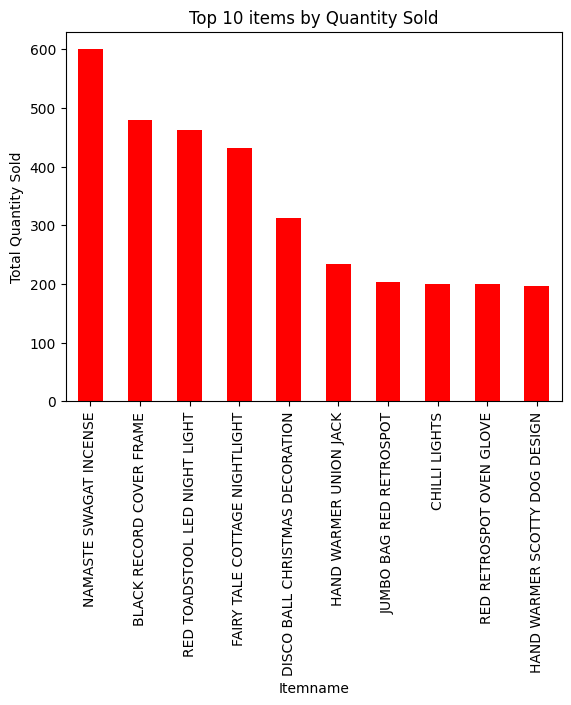

In [ ]:
#Top Selling Item by quantity
top_items = data.groupby('Itemname')['Quantity'].sum().sort_values(ascending=False).head(10)
top_items.plot(kind='bar', title = 'Top 10 items by Quantity Sold', color = 'Red')

plt.ylabel('Total Quantity Sold')
plt.show()

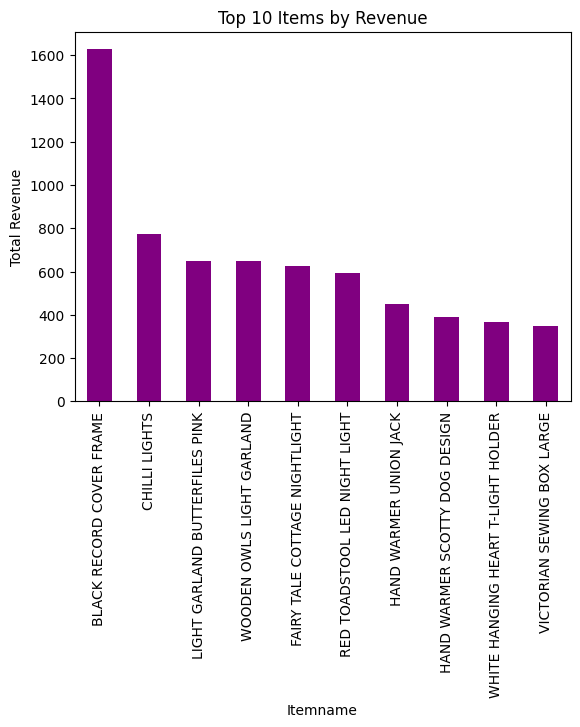

In [ ]:
#Revenue Trends
revenue_by_item = data.groupby('Itemname')['Revenue'].sum().sort_values(ascending=False).head(10)
revenue_by_item.plot(kind='bar', title = 'Top 10 Items by Revenue', color='Purple')
plt.ylabel('Total Revenue')
plt.show()

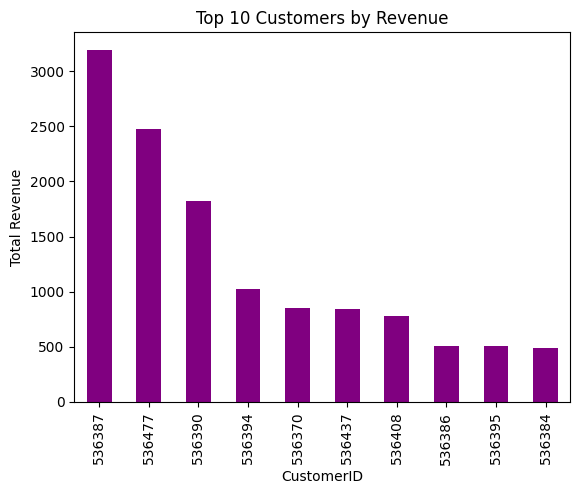

In [ ]:
# 3. Customer Purchase Revennue
customer_revenue = data.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).head(10)
customer_revenue.plot(kind='bar', title='Top 10 Customers by Revenue', color='purple')
plt.ylabel('Total Revenue')
plt.show()

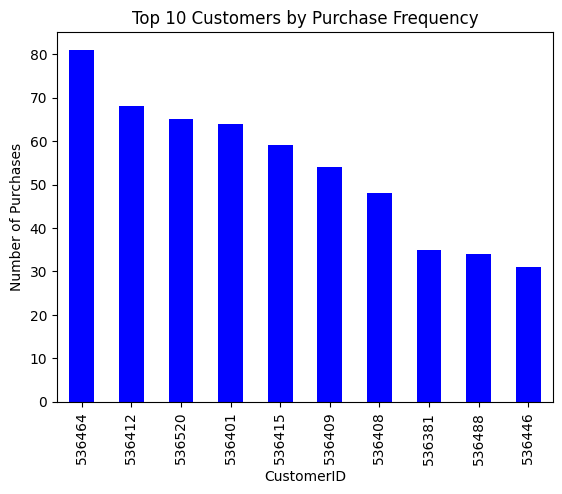

In [ ]:
# 4. Customer Purchase Behaviour
purchase_frequency = data['CustomerID'].value_counts().head(10)
purchase_frequency.plot(kind='bar', title = 'Top 10 Customers by Purchase Frequency',color = 'Blue')
plt.ylabel('Number of Purchases')
plt.show()

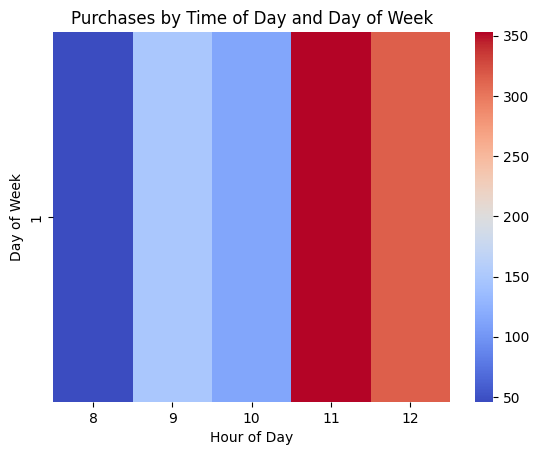

In [ ]:
data['Present_Date'] = pd.to_datetime(data['Present_Date'])
heatmap_data = data.copy()
heatmap_data['Hour'] = heatmap_data['Present_Date'].dt.hour
heatmap_data['DayOfWeek'] = heatmap_data['Present_Date'].dt.dayofweek
hourly_purchases = heatmap_data.groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)
sns.heatmap(hourly_purchases, cmap='coolwarm', annot=False, cbar=True)
plt.title('Purchases by Time of Day and Day of Week')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()

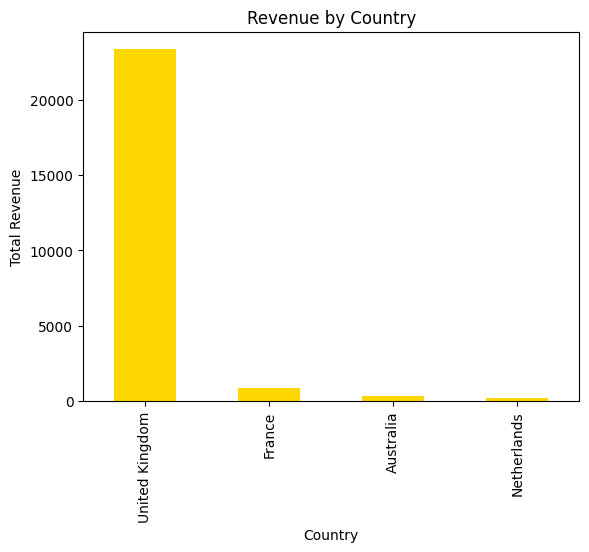

In [ ]:
# 5. Country Analysis
revenue_by_country = data.groupby('Country')['Revenue'].sum().sort_values(ascending=False)
revenue_by_country.plot(kind='bar', title='Revenue by Country', color='gold')
plt.ylabel('Total Revenue')
plt.show()

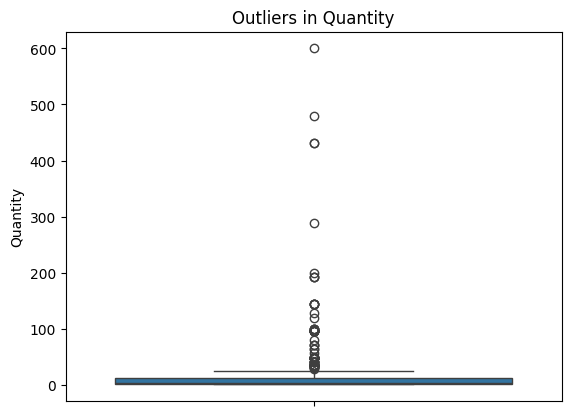

In [ ]:
# 7. Outliers in Quantity
sns.boxplot(data=data, y='Quantity')
plt.title('Outliers in Quantity')
plt.show()


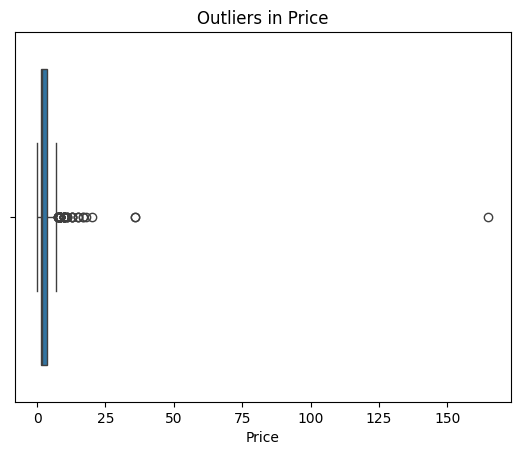

In [ ]:
# Outliers in Price
sns.boxplot(data=data,x='Price')
plt.title('Outliers in Price')
plt.show()

Skewness: 9.145808022639388
Kurtosis: 106.29090774906057
Shapiro-Wilk Test Statistic: 0.2790255212140734, P-value: 9.71143832514603e-52
The data does not follow a normal distribution (Reject H0).


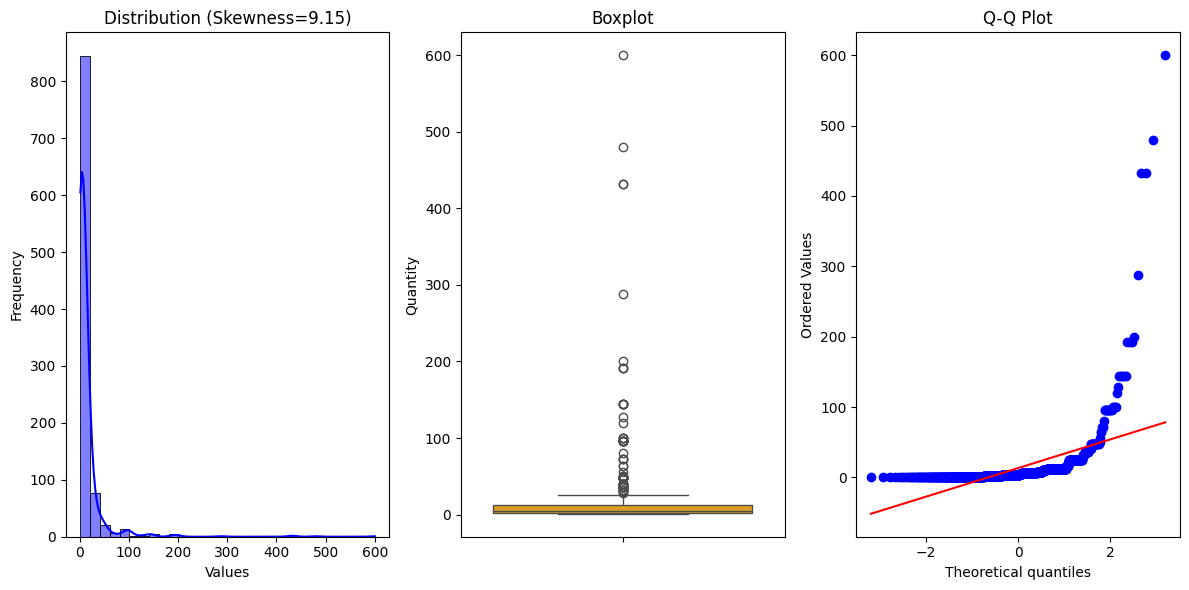

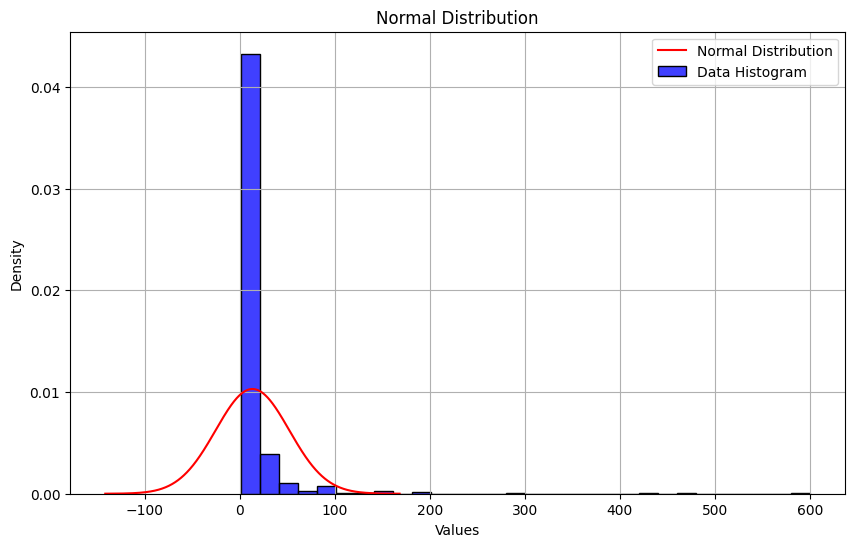

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

# Step 1: Load the dataset
# Replace 'your_dataset.csv' and 'column_name' with your file and column
df = pd.read_csv('purchase_pattern_analysis_table.csv')
data = df['Quantity']  # Replace with your column name

# Step 2: Calculate Skewness and Kurtosis
data_skewness = skew(data)
data_kurtosis = kurtosis(data)
print(f"Skewness: {data_skewness}")
print(f"Kurtosis: {data_kurtosis}")

# Step 3: Check for Normality using the Shapiro-Wilk Test
shapiro_test_stat, shapiro_p_value = shapiro(data)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_stat}, P-value: {shapiro_p_value}")

if shapiro_p_value > 0.05:
    print("The data follows a normal distribution (Fail to reject H0).")
else:
    print("The data does not follow a normal distribution (Reject H0).")

# Step 4: Visualize the Distribution
plt.figure(figsize=(12, 6))

# Histogram with KDE
plt.subplot(1, 3, 1)
sns.histplot(data, kde=True, bins=30, color='blue')
plt.title(f'Distribution (Skewness={data_skewness:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Boxplot for Outliers
plt.subplot(1, 3, 2)
sns.boxplot(data, color='orange')
plt.title('Boxplot')

# Q-Q Plot for Normality Check
from scipy.stats import probplot
plt.subplot(1, 3, 3)
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Step 5: Overlay Histogram and Normal Distribution Curve
mean = data.mean()
std_dev = data.std()
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)

plt.figure(figsize=(10, 6))
sns.histplot(data, kde=False, bins=30, stat="density", color="blue", label="Data Histogram")
plt.plot(x, y, color='red', label='Normal Distribution')
plt.title('Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

# Step 1: Load the dataset
# Replace 'your_dataset.csv' and 'column_name' with your file and column
df = pd.read_csv('purchase_pattern_analysis_table.csv')
data = df['Price']  # Replace with your column name

# Step 2: Calculate Skewness and Kurtosis
data_skewness = skew(data)
data_kurtosis = kurtosis(data)
print(f"Skewness: {data_skewness}")
print(f"Kurtosis: {data_kurtosis}")

# Step 3: Check for Normality using the Shapiro-Wilk Test
shapiro_test_stat, shapiro_p_value = shapiro(data)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_stat}, P-value: {shapiro_p_value}")

if shapiro_p_value > 0.05:
    print("The data follows a normal distribution (Fail to reject H0).")
else:
    print("The data does not follow a normal distribution (Reject H0).")

# Step 4: Visualize the Distribution
plt.figure(figsize=(12, 6))

# Histogram with KDE
plt.subplot(1, 3, 1)
sns.histplot(data, kde=True, bins=30, color='blue')
plt.title(f'Distribution (Skewness={data_skewness:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Boxplot for Outliers
plt.subplot(1, 3, 2)
sns.boxplot(data, color='orange')
plt.title('Boxplot')

# Q-Q Plot for Normality Check
from scipy.stats import probplot
plt.subplot(1, 3, 3)
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Step 5: Overlay Histogram and Normal Distribution Curve
mean = data.mean()
std_dev = data.std()
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)

plt.figure(figsize=(10, 6))
sns.histplot(data, kde=False, bins=30, stat="density", color="blue", label="Data Histogram")
plt.plot(x, y, color='red', label='Normal Distribution')
plt.title('Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()
